In [1]:
import os
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from IPython.display import display, HTML
display(HTML("<style>.container { width:55% !important; }</style>"))

In [2]:
dataset_df = pd.read_json("./data/all_ads_small.json")
dataset_df = dataset_df.drop(["id", "category"], axis=1)
dataset_df.head(5)

,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
0,Nafta,Automatická,Středočeský kraj,BMW,Řada 3,1349000,26000,1
1,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3,455000,193107,5
2,Nafta,None,Jihočeský kraj,BMW,Řada 3,1510000,12000,1
3,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3,1228149,25400,1
4,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3,1703000,24000,1


In [3]:
train_numerical = dataset_df.select_dtypes(exclude=["object"])
train_numerical.fillna(0, inplace=True)
train_categoric = dataset_df.select_dtypes(include=["object"])
train_categoric.fillna("null", inplace=True)
train = train_numerical.merge(train_categoric, left_index=True, right_index=True)

train.vehicle_age.where(train.vehicle_age > 0, 0, inplace=True)

In [4]:
train.head()

,price,tachometer,vehicle_age,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb
0,1349000,26000,1,Nafta,Automatická,Středočeský kraj,BMW,Řada 3
1,455000,193107,5,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3
2,1510000,12000,1,Nafta,null,Jihočeský kraj,BMW,Řada 3
3,1228149,25400,1,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3
4,1703000,24000,1,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3


In [5]:
normalizer_tachometer = layers.Normalization(axis=None)
normalizer_tachometer.adapt(train.tachometer)
# print("normalizer_tachometer:", normalizer_tachometer(train.tachometer))

normalizer_vehicle_age = layers.Normalization()
normalizer_vehicle_age.adapt(train.vehicle_age)
# print("normalizer_vehicle_age:", normalizer_vehicle_age(train.vehicle_age))

normalizer_price = layers.Normalization()
normalizer_price.adapt(train.price)
# print("normalizer_price:", normalizer_vehicle_age(train.price))
normalizer_price_inverse = layers.Normalization(invert=True)
normalizer_price_inverse.adapt(train.price)

lookup_locality = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_locality.adapt(train.locality)
# print("lookup_locality:", lookup_locality(train.locality))

lookup_gearbox_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_gearbox_cb.adapt(train.gearbox_cb)
# print("lookup_gearbox_cb:", lookup_gearbox_cb(train.gearbox_cb))

lookup_manufacturer_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_manufacturer_cb.adapt(train.manufacturer_cb)
# print("lookup_manufacturer_cb:", lookup_manufacturer_cb(train.manufacturer_cb))

lookup_model_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_model_cb.adapt(train.model_cb)
# print("lookup_model_cb:", lookup_model_cb(train.model_cb))

lookup_fuel_cb = tf.keras.layers.StringLookup(output_mode='one_hot')
lookup_fuel_cb.adapt(train.fuel_cb)
# print("lookup_fuel_cb:", lookup_fuel_cb(train.fuel_cb))

2022-09-29 17:48:23.428656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-29 17:48:23.428752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-29 17:48:23.463155: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-29 17:48:23.516220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 17:48:23.530571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1


2022-09-29 17:48:24.079163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 17:48:24.092652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 17:48:24.647464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 17:48:24.661213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 17:48:25.207498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 17:48:25.220966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-29 17:48:25.759106: I tensorflow/core/grappler/optimizers/cust

In [6]:
inputs = {
    "tachometer": tf.keras.Input(shape=(), dtype='float64'),
    "vehicle_age": tf.keras.Input(shape=(), dtype='float64'),
    "fuel_cb": tf.keras.Input(shape=(), dtype='string'),
    "gearbox_cb": tf.keras.Input(shape=(), dtype='string'),
    "locality": tf.keras.Input(shape=(), dtype='string'),
    "manufacturer_cb": tf.keras.Input(shape=(), dtype='string'),
    "model_cb": tf.keras.Input(shape=(), dtype='string'),
}

# tachometer_output = normalizer_tachometer(inputs["tachometer"])
tachometer_output = tf.cast(tf.expand_dims(inputs["tachometer"], 0), tf.float32)

vehicle_age_output = tf.cast(tf.expand_dims(inputs["vehicle_age"], 0), tf.float32)
fuel_cb_output = lookup_fuel_cb(inputs["fuel_cb"])
gearbox_cb_output = lookup_gearbox_cb(inputs["gearbox_cb"])
locality_output = lookup_locality(inputs["locality"])
manufacturer_cb_output = lookup_manufacturer_cb(inputs["manufacturer_cb"])
model_cb_output = lookup_model_cb(inputs["model_cb"])

outputs = {
    "tachometer": tachometer_output,
    "vehicle_age": vehicle_age_output,
    "fuel_cb": fuel_cb_output,
    "gearbox_cb": gearbox_cb_output,
    "locality": locality_output,
    "manufacturer_cb": manufacturer_cb_output,
    "model_cb": model_cb_output,
}
preprocessing_model = tf.keras.Model(inputs, outputs)

In [7]:
# tf.keras.utils.plot_model(preprocessing_model, show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     expand_nested=True,
#     show_layer_activations=True)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train.drop(['price'], axis=1).tail(-2000).to_dict(orient="list"), list(train.price.tail(-2000)))).batch(1)
dataset = dataset.map(lambda x, y: (preprocessing_model(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)

# Display a preprocessed input sample.
# print(next(dataset.take(1).as_numpy_iterator()))

In [10]:
inputs = {
    "tachometer": tf.keras.Input(shape=(1, ), batch_size=None, dtype='float32'),
    "vehicle_age": tf.keras.Input(shape=(1, ), batch_size=None, dtype='float32'),
    "fuel_cb": tf.keras.Input(shape=(len(lookup_fuel_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
    "gearbox_cb": tf.keras.Input(shape=(len(lookup_gearbox_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
    "locality": tf.keras.Input(shape=(len(lookup_locality.get_vocabulary()),), batch_size=None, dtype='float32'),
    "manufacturer_cb": tf.keras.Input(shape=(len(lookup_manufacturer_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
    "model_cb": tf.keras.Input(shape=(len(lookup_model_cb.get_vocabulary()),), batch_size=None, dtype='float32'),
}

outputs0 = tf.keras.layers.Concatenate()([
    inputs["manufacturer_cb"],
    inputs["model_cb"],
])
outputs0 = tf.keras.layers.Dense(52*145, activation="relu", name="manufacturer_cb-model_cb")(outputs0)

outputs1 = tf.keras.layers.Concatenate()([
    inputs["tachometer"],
    inputs["vehicle_age"],
])
outputs1 = tf.keras.layers.Dense(2, activation="relu", name="tachometer-vehicle_age")(outputs1)

outputs2 = tf.keras.layers.Concatenate()([
    inputs["fuel_cb"],
    inputs["gearbox_cb"],
])
outputs2 = tf.keras.layers.Dense(40, activation="relu", name="fuel_cb-gearbox_cb")(outputs2)

outputs3 = tf.keras.layers.Concatenate()([
    inputs["locality"],
])
outputs3 = tf.keras.layers.Dense(15, activation="relu", name="locality")(outputs3)

outputs = tf.keras.layers.Concatenate()([
    outputs0,
    outputs1,
    outputs2,
    outputs3
])


outputs = tf.keras.layers.Dense(128, activation="relu")(outputs)
# outputs = tf.keras.layers.Dropout(0.2)(outputs)
outputs = tf.keras.layers.Dense(1)(outputs)

training_model = tf.keras.Model(inputs, outputs)

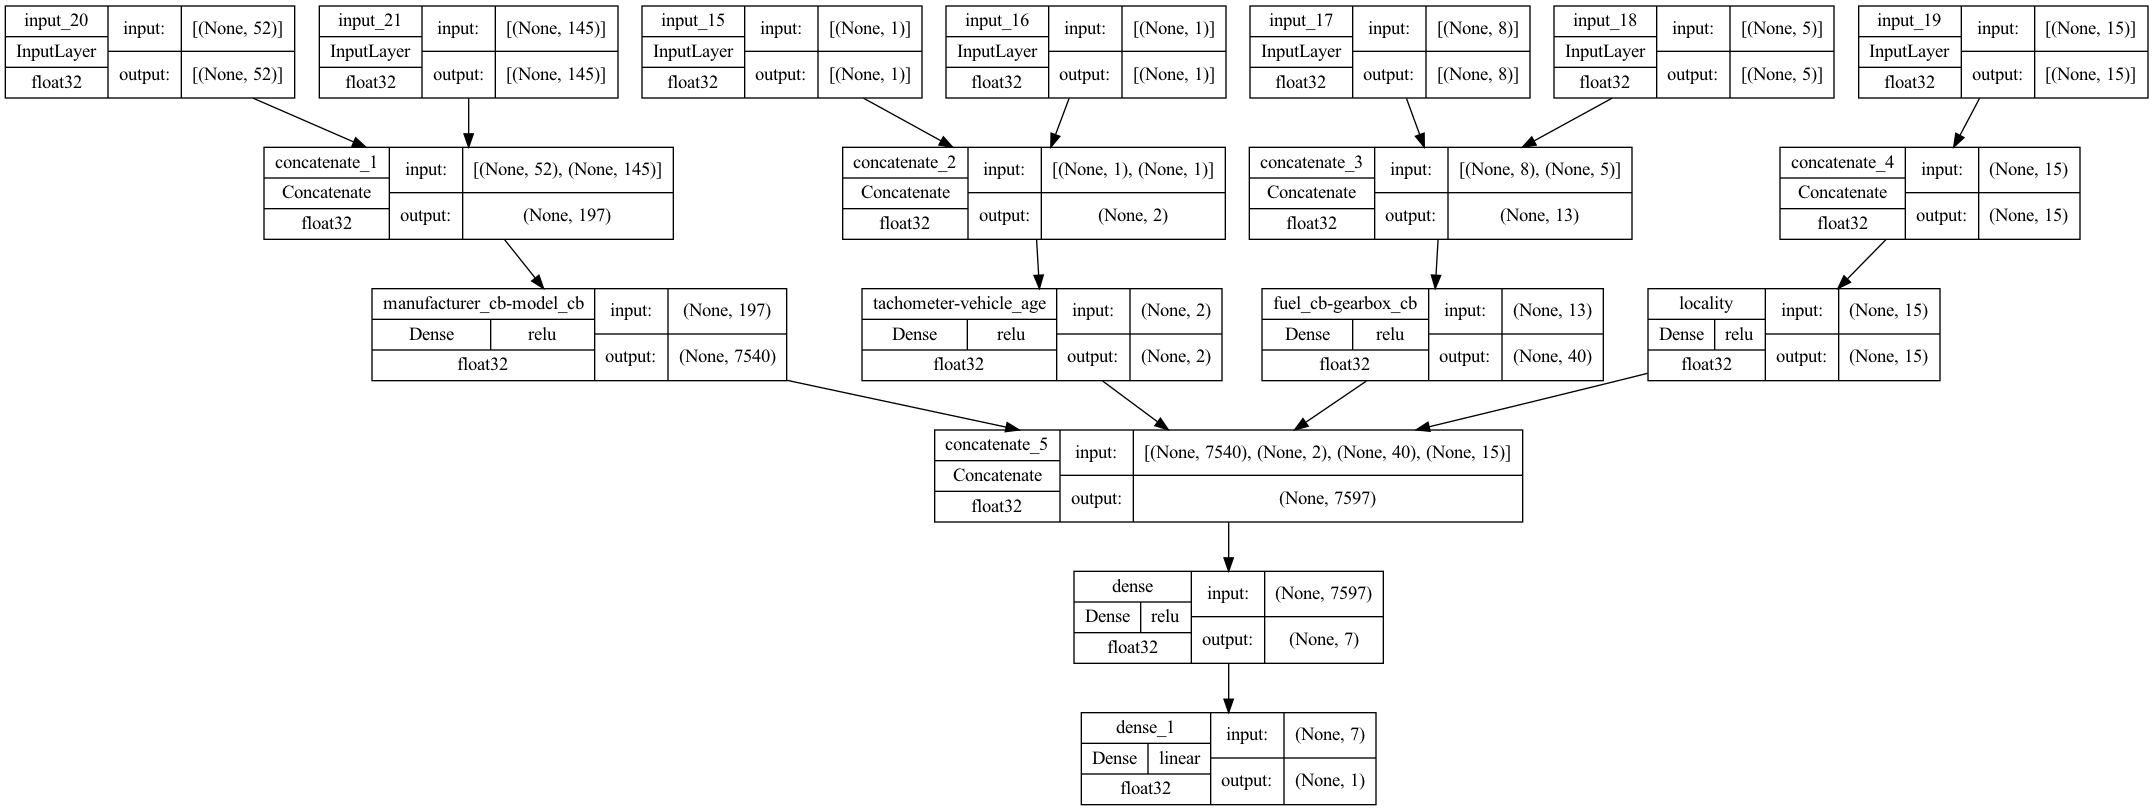

In [11]:
tf.keras.utils.plot_model(training_model, show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True)

In [12]:
training_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.2),
    loss=tf.keras.losses.mean_absolute_error
)
history = training_model.fit(dataset, epochs=5, use_multiprocessing=True)

Epoch 1/5


2022-09-29 17:48:59.914997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5895/5895 [==============================] - 38s 6ms/step - loss: 204448.5938
Epoch 2/5
5895/5895 [==============================] - 37s 6ms/step - loss: 162490.0156
Epoch 3/5
5895/5895 [==============================] - 37s 6ms/step - loss: 153107.5156
Epoch 4/5
5895/5895 [==============================] - 37s 6ms/step - loss: 148794.5938
Epoch 5/5
5895/5895 [==============================] - 37s 6ms/step - loss: 145898.8125


In [13]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs, outputs)

inputs_to_predict = train.drop(['price'], axis=1).head(2000).to_dict(orient="list")
predict_dataset = tf.data.Dataset.from_tensor_slices(inputs_to_predict).batch(1)
predictions = inference_model.predict(predict_dataset)

  26/2000 [..............................] - ETA: 8s

2022-09-29 17:52:06.274895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - 8s 4ms/step


In [14]:
pd.options.display.float_format = '{:.0f}'.format

df_results = pd.DataFrame({"predicted": predictions.flatten(), "real": train.price.head(2000)})
df_results["diff"] = df_results.real - df_results.predicted
df_results["diff_abs"] = abs(df_results.real - df_results.predicted)
df_results["diff_abs_round"] = round(abs(df_results.real - df_results.predicted), -3)
df_results = df_results.merge(dataset_df, left_index=True, right_index=True).head(2000)
df_results.head(20)

,predicted,real,diff,diff_abs,diff_abs_round,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
0,1344250,1349000,4750,4750,5000,Nafta,Automatická,Středočeský kraj,BMW,Řada 3,1349000,26000,1
1,401421,455000,53579,53579,54000,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3,455000,193107,5
2,1406419,1510000,103581,103581,104000,Nafta,None,Jihočeský kraj,BMW,Řada 3,1510000,12000,1
3,1348022,1228149,-119873,119873,120000,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3,1228149,25400,1
4,1349659,1703000,353341,353341,353000,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3,1703000,24000,1
5,1250911,1295000,44089,44089,44000,Nafta,Automatická,Moravskoslezský kraj,BMW,Řada 3,1295000,39000,2
6,290299,82000,-208299,208299,208000,Benzín,Manuální,Středočeský kraj,BMW,Řada 3,82000,275808,19
7,1353709,1530650,176941,176941,177000,Nafta,None,Pardubický kraj,BMW,Řada 3,1530650,19000,1
8,416695,109000,-307695,307695,308000,Benzín,Manuální,Moravskoslezský kraj,BMW,Řada 3,109000,170600,16
9,1450018,1572999,122981,122981,123000,Nafta,Automatická,Hlavní město Praha,BMW,Řada 3,1572999,12000,1


In [15]:
# worst
df_results.sort_values(by='diff_abs_round', ascending=False).head(20)

,predicted,real,diff,diff_abs,diff_abs_round,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
1520,1112366,6290000,5177634,5177634,5178000,Benzín,Automatická,Hlavní město Praha,Alfa Romeo,Giulia,6290000,10,0
670,2401976,6200000,3798024,3798024,3798000,Elektro,Automatická,Hlavní město Praha,Porsche,Taycan,6200000,50,2
1002,1561705,5064758,3503053,3503053,3503000,Benzín,Automatická,Hlavní město Praha,Aston Martin,Ostatní,5064758,20,1
407,962433,4299999,3337566,3337566,3338000,Benzín,Automatická,Středočeský kraj,McLaren,MP4-12C,4299999,20000,10
661,2307212,5242000,2934788,2934788,2935000,Elektro,Automatická,Středočeský kraj,Porsche,Taycan,5242000,12547,0
783,1429283,4190000,2760717,2760717,2761000,Benzín,Automatická,Hlavní město Praha,Ferrari,California,4190000,13000,6
659,2402446,5115510,2713064,2713064,2713000,Elektro,Automatická,Hlavní město Praha,Porsche,Taycan,5115510,0,0
430,1375486,3899000,2523514,2523514,2524000,Benzín,Automatická,Karlovarský kraj,Mercedes-Benz,GLE,3899000,19363,1
480,1521436,3989000,2467564,2467564,2468000,Benzín,Automatická,Hlavní město Praha,Mercedes-Benz,GLE,3989000,0,0
481,1521382,3989000,2467618,2467618,2468000,Benzín,Automatická,Hlavní město Praha,Mercedes-Benz,GLE,3989000,0,1


In [16]:
# best
df_results.sort_values(by='diff_abs_round', ascending=True).head(30)

,predicted,real,diff,diff_abs,diff_abs_round,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
1329,1589846,1589900,54,54,0,Nafta,Automatická,Plzeňský kraj,Volvo,XC60,1589900,1,0
1560,529352,529000,-352,352,0,Nafta,Automatická,Středočeský kraj,Škoda,Superb,529000,102778,4
623,284582,285000,418,418,0,Benzín,Manuální,Hlavní město Praha,Škoda,Fabia,285000,51435,7
788,980358,979900,-458,458,0,Nafta,Automatická,Hlavní město Praha,Škoda,Kodiaq,979900,19700,1
143,49674,49900,226,226,0,Nafta,None,Jihomoravský kraj,Škoda,Fabia,49900,262000,20
1789,1450248,1449000,-1248,1248,1000,Hybridní,Automatická,Středočeský kraj,BMW,Řada 3,1449000,10000,0
326,726310,725000,-1310,1310,1000,Benzín,Automatická,Jihočeský kraj,Škoda,Karoq,725000,27379,1
32,459284,459990,706,706,1000,Nafta,Automatická,Karlovarský kraj,BMW,Řada 3,459990,166581,4
750,181440,180000,-1440,1440,1000,Benzín,Manuální,Hlavní město Praha,Volkswagen,Polo,180000,145776,8
625,69664,69000,-664,664,1000,Benzín,Manuální,Ústecký kraj,Škoda,Fabia,69000,228733,14


In [18]:
df_results.sort_values(by='diff_abs_round', ascending=True).to_html("")

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>predicted</th>\n      <th>real</th>\n      <th>diff</th>\n      <th>diff_abs</th>\n      <th>diff_abs_round</th>\n      <th>fuel_cb</th>\n      <th>gearbox_cb</th>\n      <th>locality</th>\n      <th>manufacturer_cb</th>\n      <th>model_cb</th>\n      <th>price</th>\n      <th>tachometer</th>\n      <th>vehicle_age</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>1329</th>\n      <td>1589846</td>\n      <td>1589900</td>\n      <td>54</td>\n      <td>54</td>\n      <td>0</td>\n      <td>Nafta</td>\n      <td>Automatická</td>\n      <td>Plzeňský kraj</td>\n      <td>Volvo</td>\n      <td>XC60</td>\n      <td>1589900</td>\n      <td>1</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>1560</th>\n      <td>529352</td>\n      <td>529000</td>\n      <td>-352</td>\n      <td>352</td>\n      <td>0</td>\n      <td>Nafta</td>\n      <td>Automatická</td>\n      <td>Stř

In [17]:
df_results.describe()

,predicted,real,diff,diff_abs,diff_abs_round,price,tachometer,vehicle_age
count,2000,2000,2000,2000,2000,2000,2000,2000
mean,682432,795980,113548,299278,299273,795980,90621,6
std,451606,808863,509750,427940,427948,808863,87758,6
min,5,22000,-897711,54,0,22000,0,0
25%,346736,250000,-145187,66384,66000,250000,14944,1
50%,552361,532000,-17243,164101,164000,532000,65080,3
75%,941705,999900,204497,349756,350000,999900,149498,9
max,2402446,6290000,5177634,5177634,5178000,6290000,429282,41
